In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate 
import qiime2
from qiime2.plugins.feature_table.methods import rarefy


In [2]:
%cd /storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_2202/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_2202


## 1. read and separate data between two subjects

In [3]:
FEATURE_TABLE_FILE = '2202_feature_table.tsv'
METADATA_FILE = '2202_metadata.tsv'

In [4]:
#read feature table and metadata
feature_table = pd.read_csv(FEATURE_TABLE_FILE,
                            sep = '\t', 
                            skiprows = [0],
                            index_col=[0]
                           )

metadata = pd.read_csv(METADATA_FILE,
                       sep = '\t'
                      )

In [5]:
#select only feces samples
feature_table = feature_table.filter(like = 'Stool')
metadata_gut = metadata[metadata['body_site'] == 'UBERON:feces'].dropna(subset = ['collection_day'])

In [6]:
#filter from metadata samples that are not in feature table
missing_samples = ['2202.Stool13', '2202.Stool120', '2202.Stool217', '2202.Stool36', '2202.Stool147', '2202.Stool196', '2202.Stool85', '2202.Stool448']
metadata_gut = metadata_gut[~metadata_gut['sample_id'].isin(missing_samples)]

In [7]:
#separate metadata for s1 and s2 for dict
metadata_s1 = metadata_gut[metadata_gut['host_subject_id'] == 'DonorA']
metadata_s2 = metadata_gut[metadata_gut['host_subject_id'] == 'DonorB']

In [8]:
print('number of samples for donor A: {} and for donor B: {}'.format(len(metadata_s1['sample_id']), len(metadata_s2['sample_id'])))

number of samples for donor A: 334 and for donor B: 191


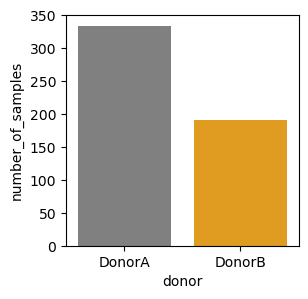

In [9]:
#plot timepoints
samples_df = pd.DataFrame(list(zip(['DonorA', 'DonorB'], [len(metadata_s1['sample_id']), len(metadata_s2['sample_id'])])),
                          columns = ['donor', 'number_of_samples'])

plt.figure(figsize = [3, 3])
sns.barplot(data = samples_df, x = 'donor', y='number_of_samples', palette = ['Grey', 'Orange'])
plt.show()

In [10]:
#filter feature tables for s1 and s2
s1_df = feature_table[metadata_s1['sample_id']]
s2_df = feature_table[metadata_s2['sample_id']]

#remove duplicates, keep first
s1_df = s1_df[~s1_df.index.duplicated(keep='first')]
s2_df = s2_df[~s2_df.index.duplicated(keep='first')]

## 2. interpolate using nearest interpolation



In [11]:
#change column names into days_since_experiment_start
sample_to_day_dict_s1 = dict(zip(metadata_s1['sample_id'], metadata_s1['collection_day']))
sample_to_day_dict_s2 = dict(zip(metadata_s2['sample_id'], metadata_s2['collection_day']))

#change column names into days_since_experiment_start
s1_df_timestep = s1_df.rename(columns=sample_to_day_dict_s1).T.sort_index()
s2_df_timestep = s2_df.rename(columns=sample_to_day_dict_s2).T.sort_index()

#remove duplicates from index
s1_df_timestep = s1_df_timestep[~s1_df_timestep.index.duplicated()]
s2_df_timestep = s2_df_timestep[~s2_df_timestep.index.duplicated()]
s2_df_timestep = s2_df_timestep.iloc[:-1] #some 318 timestep

In [12]:
#check missing timepoints
def calcualte_missing_points(df):

    full_timepoints = [i for i in range(0, int(df.index[-1]))]
    missing_timepoints  = list(set(full_timepoints) - set(df.index))
    return len(missing_timepoints)

In [13]:
print('number of missing days for donor A is: {} and for donor B: {}'.format(calcualte_missing_points(s1_df_timestep), calcualte_missing_points(s2_df_timestep)))

number of missing days for donor A is: 41 and for donor B: 64


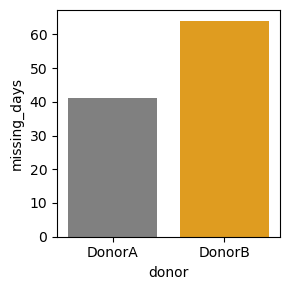

In [17]:
#plot missing timepoints
missing_days_df = pd.DataFrame(list(zip(['DonorA', 'DonorB'],
                                        [calcualte_missing_points(s1_df_timestep), calcualte_missing_points(s2_df_timestep)])),
                               columns = ['donor', 'missing_days'])

plt.figure(figsize = [3, 3])
sns.barplot(data = missing_days_df, x = 'donor', y='missing_days', palette = ['Grey', 'Orange'])
plt.tight_layout()
plt.savefig('q2202_missing_timepoints.png')
plt.show()

In [18]:
def nearest_interp(col, masked_df):
    
    #masked_df = masked_df.index.astype(int)
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #nodes
    interpolated_nodes = tmp[tmp.isna()].index.tolist() #this is being interpolated
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='nearest')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [19]:
#interpolate dataframe using nearest interpolation method
def interpolate_data(df):
    
    #check how many points are missing
    full_df = list(range(0, int(df.index[-1])))
    missing_tpoints = list(set(full_df) - set(df.index.astype(int)))

    #add missing rows to out dataframe
    df_with_missing_tpoints = df.reindex(df.index.union(missing_tpoints))

    #dataframe with only missing timepoints
    masked_df = df_with_missing_tpoints.loc[missing_tpoints]

    #missing timepoints 
    print(df_with_missing_tpoints.isna().sum()[0] )
    
    #interpolate
    interpolated_timepoints = []
    for col in df_with_missing_tpoints.columns:
        y = nearest_interp(col, df_with_missing_tpoints)
        interpolated_timepoints.append(y)
        
    nearest_df = pd.concat(interpolated_timepoints, axis=1)

    #drop columns that are 0 in all timepoints
    #nearest_df = nearest_df.loc[:, (nearest_df != 0).any(axis=0)]
    
    return nearest_df

In [20]:
interpolated_s1_df = interpolate_data(s1_df_timestep)
interpolated_s2_df = interpolate_data(s2_df_timestep)

41
64


In [134]:
#save interpolated data
interpolated_s1_df.T.to_csv('data_processing/subject1_interpolated.tsv', sep = '\t')
interpolated_s2_df.T.to_csv('data_processing/subject2_interpolated.tsv', sep = '\t')

## 3. rarefy

In [21]:
%cd data_processing/interpolation_rarefaction/

/storage/zkarwowska/zkarwowska/microbiome-interactions/datasets/processed/qiita_2202/data_processing/interpolation_rarefaction


In [ ]:
biom convert -i subject1_interpolated.tsv -o subject1_interpolated.biom --table-type="OTU table" --to-hdf5
biom convert -i subject2_interpolated.tsv -o subject2_interpolated.biom --table-type="OTU table" --to-hdf5

In [23]:
def rarefy_table(biom_file):
    
    unrarefied_table = qiime2.Artifact.import_data("FeatureTable[Frequency]", biom_file)
    #rarefy
    rarefy_result = rarefy(table=unrarefied_table, sampling_depth=16000)
    rarefied_table = rarefy_result.rarefied_table
    rarefied_table_df = rarefied_table.view(pd.DataFrame)
    
    return rarefied_table_df

In [24]:
s1_interpolated_rarefied_df = rarefy_table('subject1_interpolated.biom')
s2_interpolated_rarefied_df = rarefy_table('subject2_interpolated.biom')

## 4. reinterpolate missing timepoints that were lost after rarefaction

In [25]:
def reinterpolate_data(df):
    
    missing_timepoints_after_rarefaction = list(set([float(i) for i in range(0, df.shape[0])]) - set(df.index.astype(float)))
    rarefied_df_with_missing_tpoints = df.reindex(df.index.union(missing_timepoints_after_rarefaction))
    rarefied_df_with_missing_tpoints.index = rarefied_df_with_missing_tpoints.index.astype(float)

    interpolated_timepoints = []
    for col in rarefied_df_with_missing_tpoints.columns:
        y = nearest_interp(col, rarefied_df_with_missing_tpoints)
        interpolated_timepoints.append(y)

    nearest_rarefied_interpolated_df = pd.concat(interpolated_timepoints, axis=1)
    nearest_rarefied_interpolated_df.index = nearest_rarefied_interpolated_df.index.astype(int)
    nearest_rarefied_interpolated_df.index.name = '#OTU ID'
    
    return nearest_rarefied_interpolated_df

In [26]:
s1_reinterpolated_rarefied_df = reinterpolate_data(s1_interpolated_rarefied_df)
s2_reinterpolated_rarefied_df = reinterpolate_data(s2_interpolated_rarefied_df)

In [27]:
print(s1_reinterpolated_rarefied_df.shape, s2_reinterpolated_rarefied_df.shape)

(365, 1547) (253, 1528)


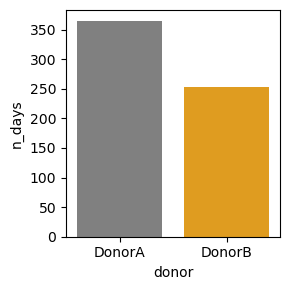

In [39]:
days_s1 = int(s1_reinterpolated_rarefied_df.shape[0])
days_s2 = int(s2_reinterpolated_rarefied_df.shape[0])

days_df = pd.DataFrame(list(zip(['DonorA', 'DonorB'], [days_s1, days_s2])),
                       columns = ['donor', 'n_days'])

plt.figure(figsize = [3, 3])
sns.barplot(data = days_df, x = 'donor', y='n_days', palette = ['Grey', 'Orange'])
plt.tight_layout()
plt.savefig('q2202_timepoints.png')
plt.show()

In [150]:
s1_reinterpolated_rarefied_df.sort_index().to_csv('donorA_rarefied_interpolated_feces.csv')
s2_reinterpolated_rarefied_df.sort_index().to_csv('donorB_rarefied_interpolated_feces.csv')

In [ ]:
#prepare data for alpha diversity testing - sample sample id that in metadata'
''' reverse_sample_to_day_dict_s1 = dict(zip(metadata_s1['collection_day'], metadata_s1['sample_id']))
dfA = pd.read_csv('data_processing/donorA_rarefied_interpolated_feces.csv')
dfA = dfA.replace({'#OTU ID' : reverse_sample_to_day_dict_s1})
dfA.to_csv('data_processing/donorA_rarefied_interpolated_feces_original_sample_id.tsv', sep = '\t')

reverse_sample_to_day_dict_s2 = dict(zip(metadata_s2['collection_day'], metadata_s2['sample_id']))
dfB = pd.read_csv('data_processing/donorB_rarefied_interpolated_feces.csv')
dfB = dfB.replace({'#OTU ID' : reverse_sample_to_day_dict_s2})
dfB.to_csv('data_processing/donorB_rarefied_interpolated_feces_original_sample_id.tsv', sep = '\t')'''